We visualize the loss landscape by simulating a synthetic registration problem. To do this, we start by simulating a DRR from a known angle, which will serve as the `target` for registration.

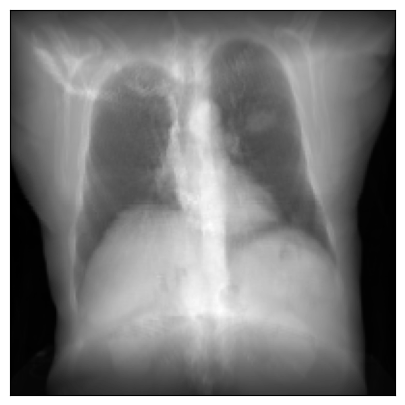

In [ ]:
#| code-fold: true
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.metrics import NormalizedCrossCorrelation2d
from diffdrr.visualization import plot_drr

# Read in the volume
volume, spacing = load_example_ct()
device = "cuda" if torch.cuda.is_available() else "cpu"
drr = DRR(volume, spacing, sdr=300.0, height=200, delx=4.0).to(device)

# Get parameters for the detector
alpha, beta, gamma = torch.pi, 0.0, torch.pi / 2
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
rotations = torch.tensor([[alpha, beta, gamma]]).to(device)
translations = torch.tensor([[bx, by, bz]]).to(device)

# Make the DRR
target_drr = drr(
    rotations, translations, parameterization="euler_angles", convention="ZYX"
)
plot_drr(target_drr, ticks=False)
plt.show()

Next, we create a function that measures the normalized cross-correlation between the `target` DRR and a `moving` DRR, simulated by some perturbation from the true parameters of the `target` DRR.

In [ ]:
metric = NormalizedCrossCorrelation2d()


def get_metric(alpha, beta, gamma, bx, by, bz):
    rotations = torch.tensor([[alpha, beta, gamma]]).to(device)
    translations = torch.tensor([[bx, by, bz]]).to(device)
    moving_drr = drr(
        rotations, translations, parameterization="euler_angles", convention="ZYX"
    )
    return metric(target_drr, moving_drr)

Finally, we can simulate hundreds of `moving` DRRs and measure their cross correlation with the `target`.
Plotting the cross correlation versus the perturbation from the true DRR parameters allows us to visualize
the loss landscape for the six pose parameters. From this visualization, we see that the loss landscape
is convex in this neighborhood (±15 mm and ±180 degrees).

βγ: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.48it/s]


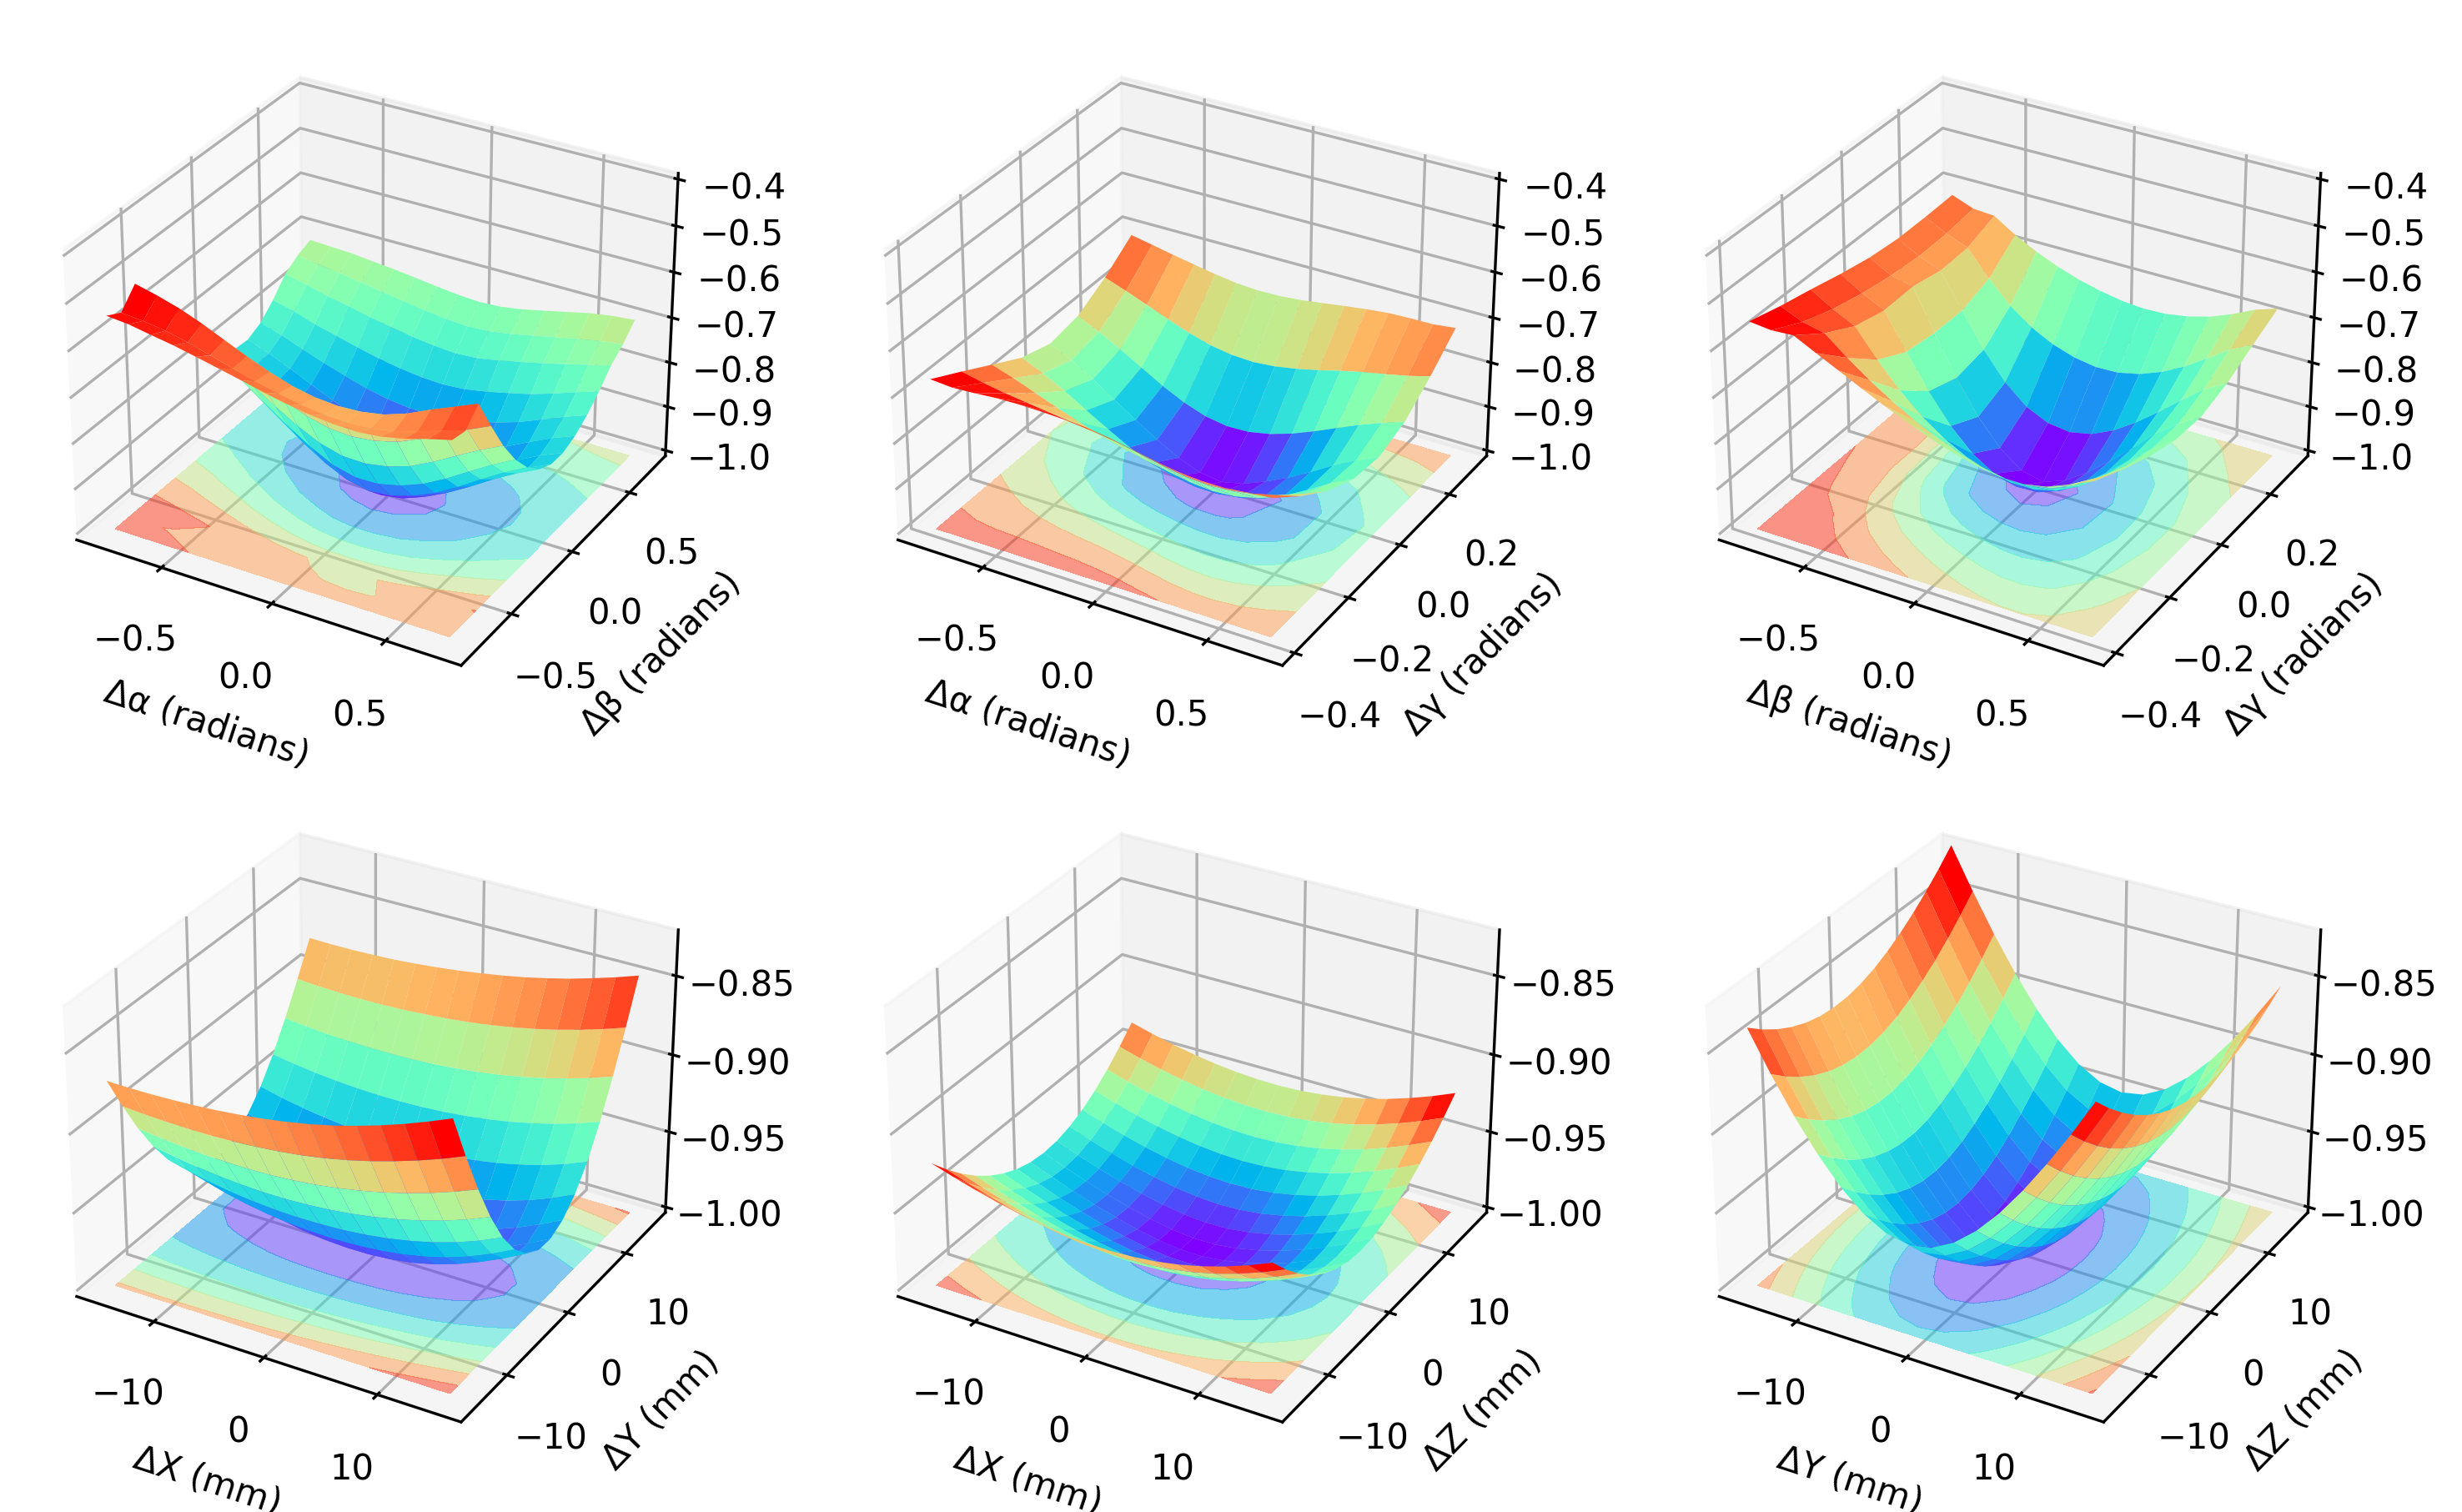

In [ ]:
#| code-fold: true
### NCC for the XYZs
xs = torch.arange(-15.0, 16.0, step=2)
ys = torch.arange(-15.0, 16.0, step=2)
zs = torch.arange(-15.0, 16.0, step=2)

# Get coordinate-wise correlations
xy_corrs = []
for x in tqdm(xs, desc="XY"):
    for y in ys:
        xcorr = get_metric(alpha, beta, gamma, bx + x, by + y, bz)
        xy_corrs.append(-xcorr)
XY = torch.tensor(xy_corrs).reshape(len(xs), len(ys))

xz_corrs = []
for x in tqdm(xs, desc="XZ"):
    for z in zs:
        xcorr = get_metric(alpha, beta, gamma, bx + x, by, bz + z)
        xz_corrs.append(-xcorr)
XZ = torch.tensor(xz_corrs).reshape(len(xs), len(zs))

yz_corrs = []
for y in tqdm(ys, desc="YZ"):
    for z in zs:
        xcorr = get_metric(alpha, beta, gamma, bx, by + y, bz + z)
        yz_corrs.append(-xcorr)
YZ = torch.tensor(yz_corrs).reshape(len(ys), len(zs))

### NCC for the angles
a_angles = torch.arange(-torch.pi / 4, torch.pi / 4, step=0.1)
b_angles = torch.arange(-torch.pi / 4, torch.pi / 4, step=0.1)
g_angles = torch.arange(-torch.pi / 8, torch.pi / 8, step=0.1)

# Get coordinate-wise correlations
tp_corrs = []
for t in tqdm(a_angles, desc="αβ"):
    for p in b_angles:
        xcorr = get_metric(alpha + t, beta + p, gamma, bx, by, bz)
        tp_corrs.append(-xcorr)
TP = torch.tensor(tp_corrs).reshape(len(a_angles), len(b_angles))

tg_corrs = []
for t in tqdm(a_angles, desc="αγ"):
    for g in g_angles:
        xcorr = get_metric(alpha + t, beta, gamma + g, bx, by, bz)
        tg_corrs.append(-xcorr)
TG = torch.tensor(tg_corrs).reshape(len(a_angles), len(g_angles))

pg_corrs = []
for p in tqdm(b_angles, desc="βγ"):
    for g in g_angles:
        xcorr = get_metric(alpha, beta + p, gamma + g, bx, by, bz)
        pg_corrs.append(-xcorr)
PG = torch.tensor(pg_corrs).reshape(len(b_angles), len(g_angles))

### Make the plots

# XYZ
xyx, xyy = torch.meshgrid(xs, ys, indexing="ij")
xzx, xzz = torch.meshgrid(xs, zs, indexing="ij")
yzy, yzz = torch.meshgrid(ys, zs, indexing="ij")

fig = plt.figure(figsize=3 * plt.figaspect(1.2 / 1), dpi=300)

ax = fig.add_subplot(1, 3, 1, projection="3d")
ax.contourf(xyx, xyy, XY, zdir="z", offset=-1, cmap=plt.get_cmap("rainbow"), alpha=0.5)
ax.plot_surface(xyx, xyy, XY, rstride=1, cstride=1, cmap=plt.get_cmap("rainbow"))
ax.set_xlabel("ΔX (mm)")
ax.set_ylabel("ΔY (mm)")
ax.set_zlim3d(-1.0, -0.825)

ax = fig.add_subplot(1, 3, 2, projection="3d")
ax.contourf(xzx, xzz, XZ, zdir="z", offset=-1, cmap=plt.get_cmap("rainbow"), alpha=0.5)
ax.plot_surface(xzx, xzz, XZ, rstride=1, cstride=1, cmap=plt.get_cmap("rainbow"))
ax.set_xlabel("ΔX (mm)")
ax.set_ylabel("ΔZ (mm)")
ax.set_zlim3d(-1.0, -0.825)

ax = fig.add_subplot(1, 3, 3, projection="3d")
ax.contourf(yzy, yzz, YZ, zdir="z", offset=-1, cmap=plt.get_cmap("rainbow"), alpha=0.5)
ax.plot_surface(yzy, yzz, YZ, rstride=1, cstride=1, cmap=plt.get_cmap("rainbow"))
ax.set_xlabel("ΔY (mm)")
ax.set_ylabel("ΔZ (mm)")
ax.set_zlim3d(-1.0, -0.825)

# Angles
xyx, xyy = torch.meshgrid(a_angles, b_angles, indexing="ij")
xzx, xzz = torch.meshgrid(a_angles, g_angles, indexing="ij")
yzy, yzz = torch.meshgrid(b_angles, g_angles, indexing="ij")

ax = fig.add_subplot(2, 3, 1, projection="3d")
ax.contourf(xyx, xyy, TP, zdir="z", offset=-1, cmap=plt.get_cmap("rainbow"), alpha=0.5)
ax.plot_surface(xyx, xyy, TP, rstride=1, cstride=1, cmap=plt.get_cmap("rainbow"))
ax.set_xlabel("Δα (radians)")
ax.set_ylabel("Δβ (radians)")
ax.set_zlim3d(-1.0, -0.4)

ax = fig.add_subplot(2, 3, 2, projection="3d")
ax.contourf(xzx, xzz, TG, zdir="z", offset=-1, cmap=plt.get_cmap("rainbow"), alpha=0.5)
ax.plot_surface(xzx, xzz, TG, rstride=1, cstride=1, cmap=plt.get_cmap("rainbow"))
ax.set_xlabel("Δα (radians)")
ax.set_ylabel("Δγ (radians)")
ax.set_zlim3d(-1.0, -0.4)

ax = fig.add_subplot(2, 3, 3, projection="3d")
ax.contourf(yzy, yzz, PG, zdir="z", offset=-1, cmap=plt.get_cmap("rainbow"), alpha=0.5)
ax.plot_surface(yzy, yzz, PG, rstride=1, cstride=1, cmap=plt.get_cmap("rainbow"))
ax.set_xlabel("Δβ (radians)")
ax.set_ylabel("Δγ (radians)")
ax.set_zlim3d(-1.0, -0.4)

plt.show()